### Chargement des données

In [6]:
import os
import zipfile

def extraire_certains_sous_dossiers(chemin_zip, dossier_cible, sous_dossiers_a_extraire):
    
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        
        liste_des_chemins = zip_ref.namelist()
        
        
        chemins_a_extraire = [chemin for chemin in liste_des_chemins for prefixe in sous_dossiers_a_extraire if chemin.startswith(prefixe)]
        
        for chemin in chemins_a_extraire:
            zip_ref.extract(chemin, dossier_cible)
            print(f"Extraction de '{chemin}' terminée.")

chemin_zip = 'MOT17.zip'
dossier_cible = 'data'



In [7]:
# sous_dossiers_a_extraire = ['MOT17/train/MOT17-02-DPM', 'MOT17/train/MOT17-05-DPM', 'MOT17/train/MOT17-09-DPM', 'MOT17/train/MOT17-04-DPM']
# extraire_certains_sous_dossiers(chemin_zip, dossier_cible, sous_dossiers_a_extraire)

In [2]:
import os
import random
import cv2
from ultralytics import YOLO
from tracker import Tracker  ## DeepSORT
import pandas as pd
import numpy as np

In [3]:
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
# print(class_list.index("cup"))

Class id :
cup = 41
person = 1

In [3]:
list_name = ["MOT17-02-DPM","MOT17-04-DPM","MOT17-05-DPM","MOT17-09-DPM"]

### DeepSort

In [4]:
import re
def get_frames_list(images_folder):
    frames_list = []
    for frame in os.listdir(images_folder):
        if frame.endswith(".jpg"):
            
            number = int(re.search(r'\d+', frame).group())
            frames_list.append((number, os.path.join(images_folder, frame)))
    
    frames_list = sorted(frames_list, key=lambda x: x[0])
    return [frame[1] for frame in frames_list]

#### Prédiction

In [ ]:
for model_name in ["yolov9c.pt""yolov8n.pt"] :
    
    for dataset_name in list_name :
        
        images_path = f"data\\frames"
        output_path = f"output\\frames"
        # images_path = f"data\\MOT17\\train\{dataset_name}\\img1"
        # output_path = f"output\\{dataset_name}"
        output_track_eval = f"TrackEval\\data\\trackers\\mot_challenge\\MOT17-train\\MPNTrack_{model_name}\\data"
        
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        if not os.path.exists(output_track_eval):
            os.makedirs(output_track_eval)
        if not os.path.exists(os.path.join(output_path,f"pred\\{model_name}")):
            os.makedirs(os.path.join(output_path, f"pred\\{model_name}"))
        if not os.path.exists(os.path.join(output_path, f"img_pred/{model_name}")):
            os.makedirs(os.path.join(output_path, f"img_pred\\{model_name}"))
        # Ouvrir un fichier pour écrire les prédictions
        output_file_path = os.path.join(output_path, f"pred\\{model_name}\\{dataset_name}.txt")
        output_file_path_trackEval = os.path.join(output_track_eval, f"{dataset_name}.txt")
        output_path_imgs = os.path.join(output_path, f"img_pred\\{model_name}")

        model = YOLO(model_name)
        tracker = Tracker()

        colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for j in range(10)]

        # Liste des fichiers dans le dossier d'images
        # images_files = sorted([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
        images_files = get_frames_list(images_path)
        #print(images_files)
        
        #Image number
        

        tracks_data = []  

        for i, image_file in enumerate(images_files):
            #image_path = os.path.join(images_path, image_file)
            frame = cv2.imread(image_file)

            results = model(frame)
            
            for result in results:
                detections = []
                for r in result.boxes.data.tolist():
                    x1, y1, x2, y2, score, class_id = r
                    
                    if class_id == 41:
                       
                        detections.append([int(x1), int(y1), int(x2), int(y2), score])

                tracker.update(frame, detections)

                for track in tracker.tracks:
                    bbox = track.bbox
                    track_id = track.track_id
                    
                    width = int(bbox[2]) - int(bbox[0])  # width = x2 - x1
                    height = int(bbox[3]) - int(bbox[1])  # height = y2 - y1
                    
                    tracks_data.append((i, track_id, int(bbox[0]), int(bbox[1]), width, height))  

                    cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (colors[track_id % len(colors)]), 3)
                    cv2.putText(frame, str(track_id), (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (colors[track_id % len(colors)]), 2)

            cv2.imwrite(os.path.join(output_path_imgs, f"{i}.jpg"), frame)
        

        # Tri
        tracks_data.sort(key=lambda x: x[1])

        
        with open(output_file_path, "w") as output_file:
            for data in tracks_data:
                output_file.write(' '.join(map(str, data)) + "\n")
        
        #Ecrire dans TrackEval
        with open(output_file_path_trackEval, "w") as output_file:
            for data in tracks_data:
                output_file.write(','.join(map(str, data)) + "\n") 


### Visualisation des identifications visuellement entre gt et prédicition

In [55]:
def draw_bounding_boxes(image_path, boxes,output_path,id):
    
    # Lire l'image
    image = cv2.imread(image_path)
    # Vérifier si l'image a été chargée correctement
    if image is None:
        print(f"Erreur lors du chargement de l'image {image_path}")
        return

    
    for box in boxes:
        x1, y1, x2, y2, obj_id = box
        # Dessiner la boîte englobante en rouge
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        # Afficher l'ID de l'objet
        cv2.putText(image, str(obj_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
       
    cv2.imwrite(os.path.join(output_path, id), image)

In [61]:
# annotations_by_image =images_gt()

In [62]:
def draw(annotations_by_image) :
    # Parcourir chaque image et dessiner les boîtes englobantes
    for image_id, boxes in annotations_by_image.items():
        image_path = os.path.join(images_folder, image_id)
        draw_bounding_boxes(image_path, boxes, output_p, image_id)
        
        

In [63]:
# draw(annotations_by_image)

In [6]:
import matplotlib.pyplot as plt

In [10]:
def plot_detection(image_name):
    
    for dataset_name in list_name :
        
        chemin_gt = f"data\\MOT17\\train\\{dataset_name}\\img_gt\\{image_name}"
        chemin_image2 = f"output\{dataset_name}\img_pred\yolov8n.pt\{image_name}"
        chemin_image3 = f"output\{dataset_name}\img_pred\yolov9c.pt\{image_name}"
        chemin_image4 = f"output\{dataset_name}\img_pred\Manu_yolov9c.pt\{image_name}"
        
        image1 = cv2.imread(chemin_gt)
        image2 = cv2.imread(chemin_image2)
        image3 = cv2.imread(chemin_image3)
        image4 = cv2.imread(chemin_image4)

        # Convertir les images de BGR à RGB (car cv2 lit les images en format BGR par défaut)
        image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        image3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
        image4_rgb = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

        # Créer une figure et afficher les images côte à côte
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(image1_rgb)
        plt.title('GT')

        plt.subplot(1, 4, 2)
        plt.imshow(image2_rgb)
        plt.title('Yolov8')

        plt.subplot(1, 4, 3)
        plt.imshow(image3_rgb)
        plt.title('Yolov9')

        plt.subplot(1, 4,4)
        plt.imshow(image4_rgb)
        plt.title('ManuTrack')
        
        plt.show()
        
        

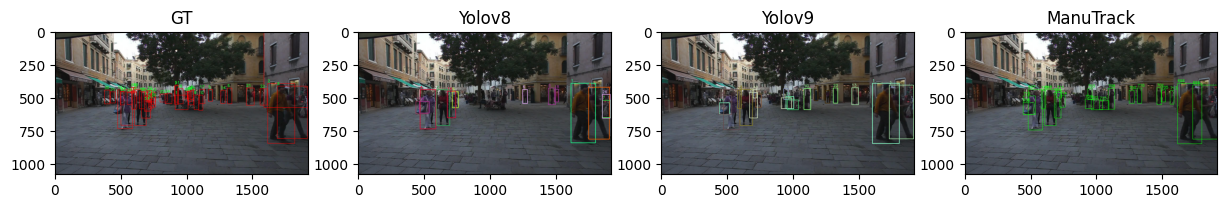

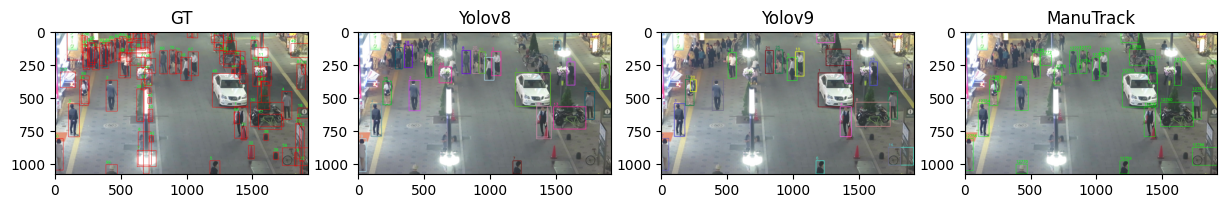

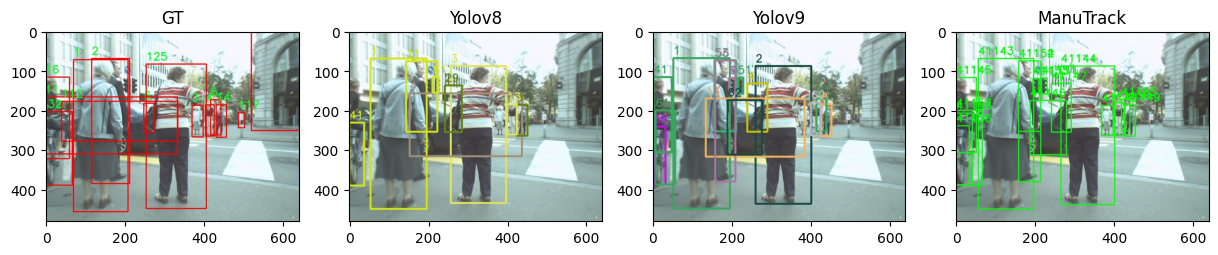

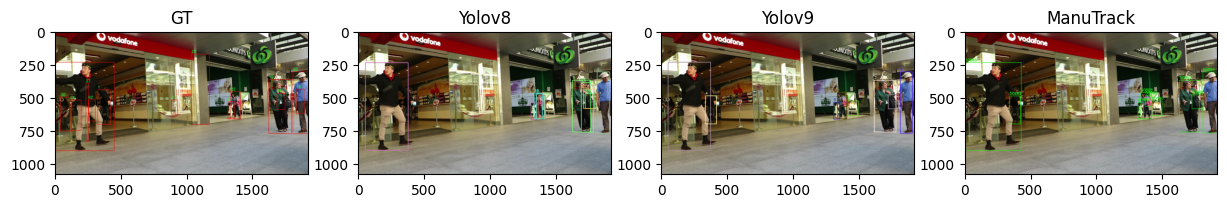

In [11]:
plot_detection("000034.jpg")

### Métrique

https://github.com/JonathonLuiten/TrackEval/tree/master/docs/MOTChallenge-Official

cd TrackEval

pip install .

In [58]:
import os
import sys
from trackeval import Evaluator
from trackeval.datasets import MotChallenge2DBox
from trackeval.metrics import HOTA, CLEAR, Identity, VACE


hota0 = dict()
output = dict()
for model_name in ["Manu_yolov9c.pt","yolov8n.pt","yolov9c.pt"]: #["Manu_yolov9c.pt","yolov8n.pt","yolov9c.pt"]
    
    # Configuration de l'évaluation
    eval_config = Evaluator.get_default_eval_config()
    eval_config['USE_PARALLEL'] = False
    eval_config['NUM_PARALLEL_CORES'] = 1
    eval_config['BREAK_ON_ERROR'] = True
    eval_config['PRINT_RESULTS'] = True
    eval_config['PRINT_ONLY_COMBINED'] = False
    eval_config['PRINT_CONFIG'] = True
    eval_config['TIME_PROGRESS'] = True
    eval_config['OUTPUT_SUMMARY'] = True
    eval_config['OUTPUT_DETAILED'] = True
    eval_config['PLOT_CURVES'] = True

    # Configuration du dataset
    dataset_config = MotChallenge2DBox.get_default_dataset_config()
    dataset_config['BENCHMARK'] = 'MOT17'
    dataset_config['SPLIT_TO_EVAL'] = 'train'
    dataset_config['TRACKERS_TO_EVAL'] = [f'MPNTrack_{model_name}']  
    dataset_config['GT_FOLDER'] = "TrackEval\\data\\gt\\mot_challenge"  
    dataset_config['TRACKERS_FOLDER'] = "TrackEval\\data\\trackers\\mot_challenge"
    dataset_config['TRACKER_SUB_FOLDER'] = 'data'  
    
    # Configuration des métriques
    metrics_config = {'METRICS': ['HOTA'], 'THRESHOLD': 0.5}

    # Création de la liste des datasets et des métriques à évaluer
    dataset_list = [MotChallenge2DBox(dataset_config)]
    metrics_list = [HOTA(metrics_config), CLEAR(metrics_config), Identity(metrics_config), VACE(metrics_config)]

    # Création et exécution de l'évaluateur
    evaluator = Evaluator(eval_config)
    output_res, output_msg = evaluator.evaluate(dataset_list, metrics_list)
    
    output[model_name] = output_res
    hota0[model_name]= []
    for dataset_name in list_name:
        hota0[model_name].append(output_res["MotChallenge2DBox"][f"MPNTrack_{model_name}"][dataset_name]["pedestrian"]["HOTA"]["HOTA(0)"])
    



MotChallenge2DBox Config:
GT_FOLDER            : TrackEval\data\gt\mot_challenge
TRACKERS_FOLDER      : TrackEval\data\trackers\mot_challenge
OUTPUT_FOLDER        : None                          
TRACKERS_TO_EVAL     : ['MPNTrack_idriss']           
CLASSES_TO_EVAL      : ['pedestrian']                
BENCHMARK            : MOT17                         
SPLIT_TO_EVAL        : train                         
INPUT_AS_ZIP         : False                         
PRINT_CONFIG         : True                          
DO_PREPROC           : True                          
TRACKER_SUB_FOLDER   :                               
OUTPUT_SUB_FOLDER    :                               
TRACKER_DISPLAY_NAMES : None                          
SEQMAP_FOLDER        : None                          
SEQMAP_FILE          : None                          
SEQ_INFO             : None                          
GT_LOC_FORMAT        : {gt_folder}/{seq}/gt/gt.txt   
SKIP_SPLIT_FOL       : False                  

<Figure size 640x480 with 0 Axes>

In [59]:
import json

def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convertit ndarray en liste
    elif isinstance(obj, np.integer):
        return int(obj)  # Convertit numpy int en int Python
    elif isinstance(obj, np.floating):
        return float(obj)  # Convertit numpy float en float Python
    elif isinstance(obj, dict):
        return {key: convert_numpy(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(item) for item in obj]
    else:
        return obj

# Convertir l'objet avant de l'écrire en JSON
output_convert = convert_numpy(output)
# Écrire les données dans un fichier JSON
output_file_path = 'output_data.json'
with open(output_file_path, 'w') as file:
    json.dump(output_convert, file, indent=4)

### Results

#### Hota(0)

In [12]:

def plot_hota0( hota0_list1, hota0_list2, hota0_list3):
    n = len(list_name)  # Nombre de datasets
    print(n)
    index = np.arange(n)  # Les positions des barres sur l'axe des x
    bar_width = 0.2  # La largeur des barres réduite pour accommoder une troisième série

    plt.figure(figsize=(12, 7))
    plt.bar(index, hota0_list1, bar_width, label='YoloV9', color='b')
    plt.bar(index + bar_width, hota0_list2, bar_width, label='YoloV8', color='r')
    plt.bar(index + 2*bar_width, hota0_list3, bar_width, label='Manu_yolov9c', color='g')  # La troisième série


    # Ajouter des titres et des étiquettes
    plt.title(f'HOTA(0) α = 0.05 ')
    plt.xlabel('Dataset')
    plt.ylabel('HOTA(0) Score')

    # Ajouter des étiquettes de valeur sur chaque barre
    for i in range(n):
        print(i)
        plt.text(i, hota0_list1[i], f'{hota0_list1[i]:.2f}', ha='center', va='bottom')
        plt.text(i + bar_width, hota0_list2[i], f'{hota0_list2[i]:.2f}', ha='center', va='bottom')
        plt.text(i + 2*bar_width, hota0_list3[i], f'{hota0_list3[i]:.2f}', ha='center', va='bottom')

    # Définir les positions des étiquettes de l'axe des x
    plt.xticks(index + bar_width, list_name, rotation=45)

    # Ajouter une légende
    plt.legend()

    # Ajuster automatiquement les paramètres du subplot pour donner un padding spécifié
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

4
0
1
2
3


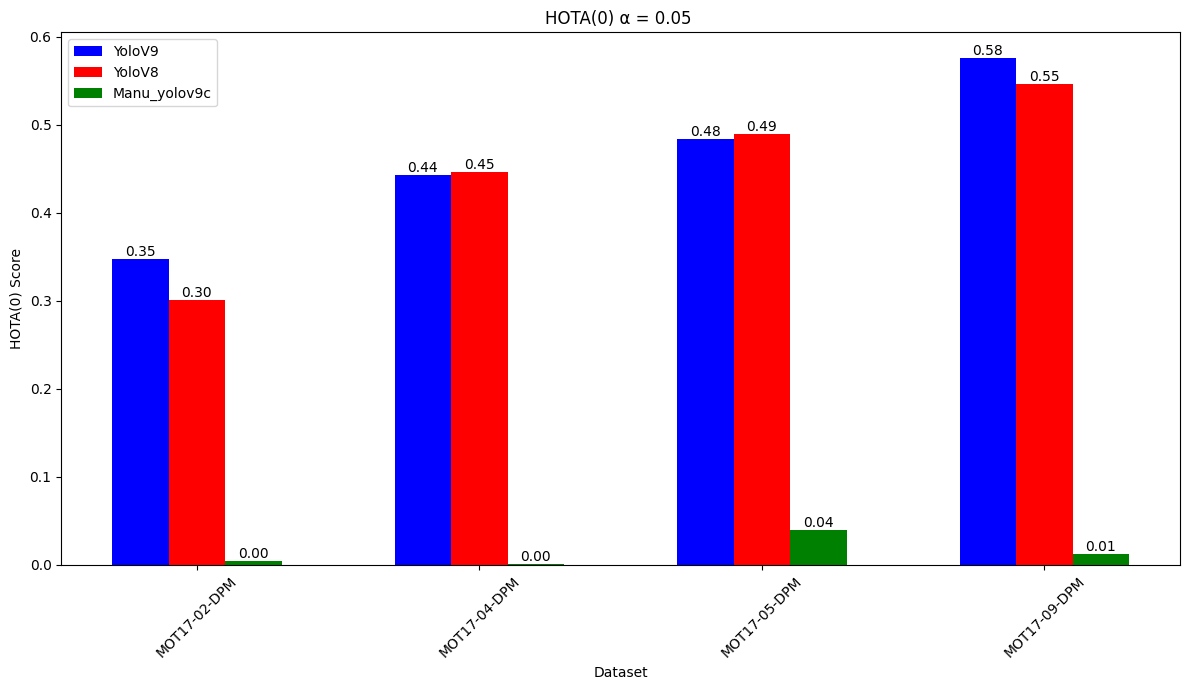

In [15]:
plot_hota0(hota0["yolov9c.pt"],hota0["yolov8n.pt"],hota0["Manu_yolov9c.pt"])

#### Graphs

In [16]:
def plot_result(data,dataset_name,model_name):
    
    hota_scores =data[model_name]["MotChallenge2DBox"][f"MPNTrack_{model_name}"][dataset_name]["pedestrian"]["HOTA"]["HOTA"]
    deta_scores= data[model_name]["MotChallenge2DBox"][f"MPNTrack_{model_name}"][dataset_name]["pedestrian"]["HOTA"]["DetA"]
    assa_scores =data[model_name]["MotChallenge2DBox"][f"MPNTrack_{model_name}"][dataset_name]["pedestrian"]["HOTA"]["AssA"]
    loca_scores =data[model_name]["MotChallenge2DBox"][f"MPNTrack_{model_name}"][dataset_name]["pedestrian"]["HOTA"]["AssA"]
    
    alpha_thresholds = np.linspace(0, 1, num=19)
    plt.figure(figsize=(10, 6))

    # Plotting
    plt.plot(alpha_thresholds, hota_scores, label="HOTA", marker='o')
    plt.plot(alpha_thresholds, deta_scores, label="DetA", marker='x')
    plt.plot(alpha_thresholds, assa_scores, label="AssA", marker='s')
    plt.plot(alpha_thresholds, loca_scores, label="AssA", marker='')

    # Customizing the plot
    plt.title(f"Tracking Performance for : {dataset_name} - {model_name}")
    plt.xlabel("Alpha")
    plt.ylabel("Scores")
    plt.legend()
    plt.grid(True)
  
    plt.show()

In [ ]:
plot_result(output,"MOT17-02-DPM","Manu_yolov9c.pt")

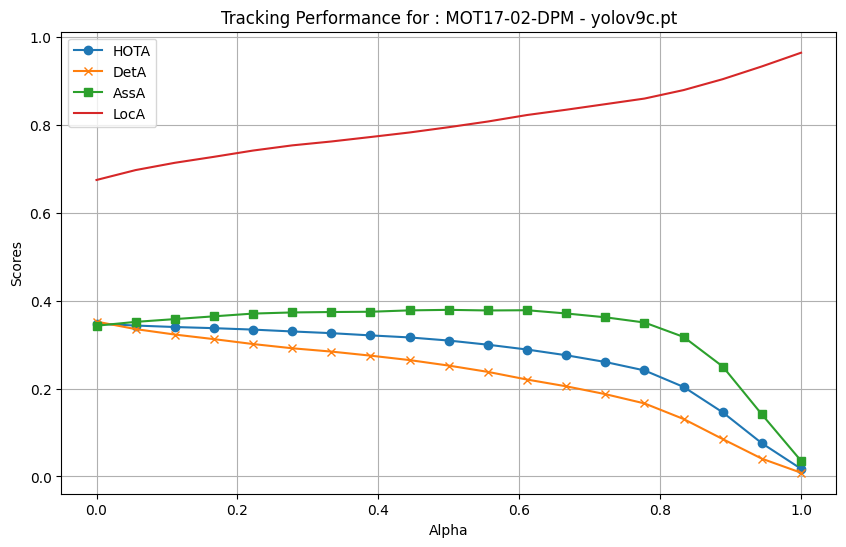

In [18]:
plot_result(output,"MOT17-02-DPM","yolov9c.pt")


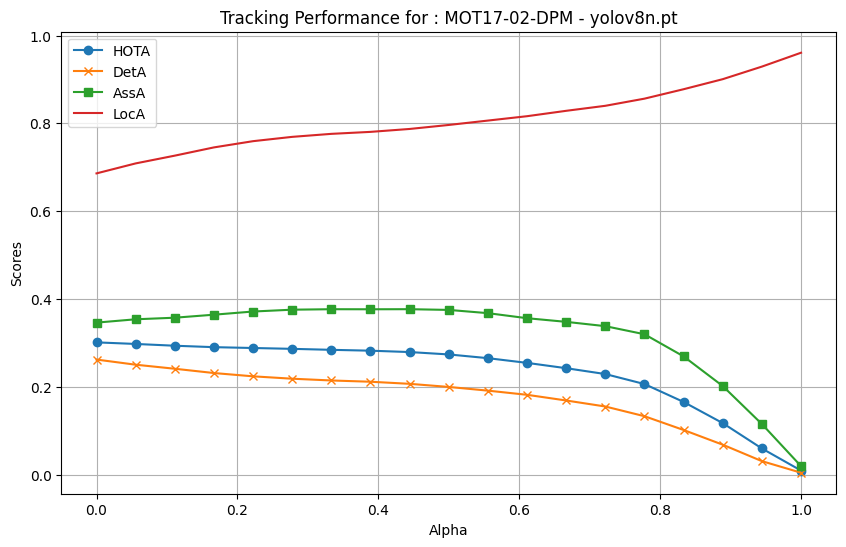

In [19]:
plot_result(output,"MOT17-02-DPM","yolov8n.pt")

In [ ]:
plot_result(output,"MOT17-04-DPM","Manu_yolov9c.pt")

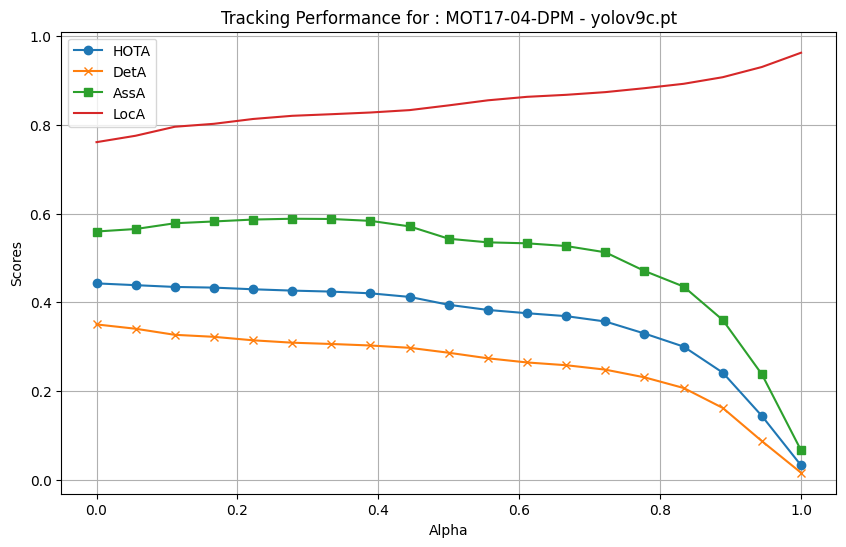

In [88]:
plot_result(output,"MOT17-04-DPM","yolov9c.pt")

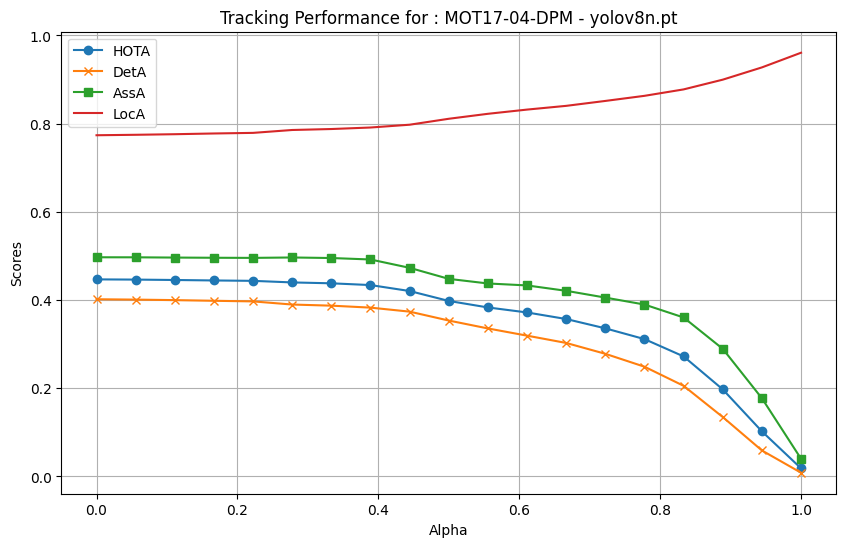

In [89]:
plot_result(output,"MOT17-04-DPM","yolov8n.pt")

In [29]:


data = {
    
    'DetA': [26,35],
    'AssA': [34.5,35]
}

df = pd.DataFrame(data)


def plot_scatter(df,dataset_name):
    
    # Création du scatter plot
    plt.scatter(df['AssA'], df['DetA'])

    list_model= ["yolov8n","yolov9c"]
    for i in range(len(df)):
        plt.text(df['AssA'][i], df['DetA'][i], str(list_model[i]),color = 'red',fontsize = 11)


    x = np.linspace(20, 45, 5)
    y = np.linspace(25, 40, 5)
    X, Y = np.meshgrid(x, y)
    Z = np.sqrt(X * Y)  

    contour = plt.contour(X, Y, Z, levels=10, colors='black')
    plt.clabel(contour, inline=True, fontsize=8)

    
    plt.title(f'AssA(0) vs DetA(0) (HOTA(0)) - {dataset_name}')
    plt.ylabel('DetA(0)')
    plt.xlabel('AssA(0)')

    # Afficher le graphique
    plt.show()

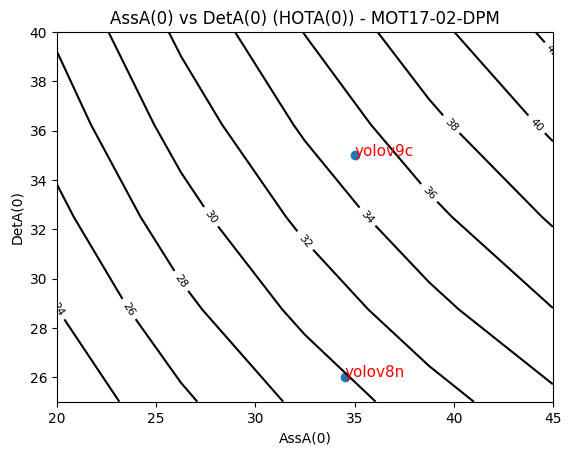

In [30]:
plot_scatter(df,"MOT17-02-DPM")

In [24]:
plot_result(output,"MOT17-05-DPM","Manu_yolov9c.pt")

NameError: name 'plot_result' is not defined

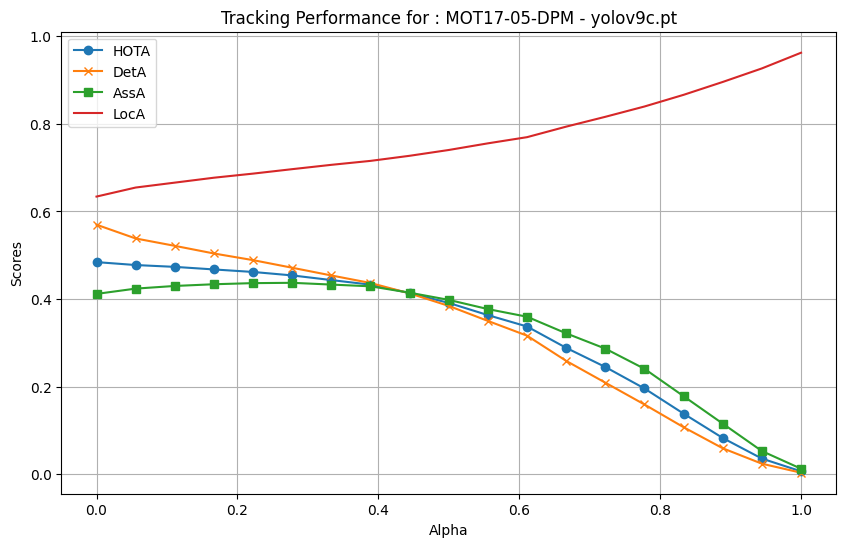

In [90]:
plot_result(output,"MOT17-05-DPM","yolov9c.pt")

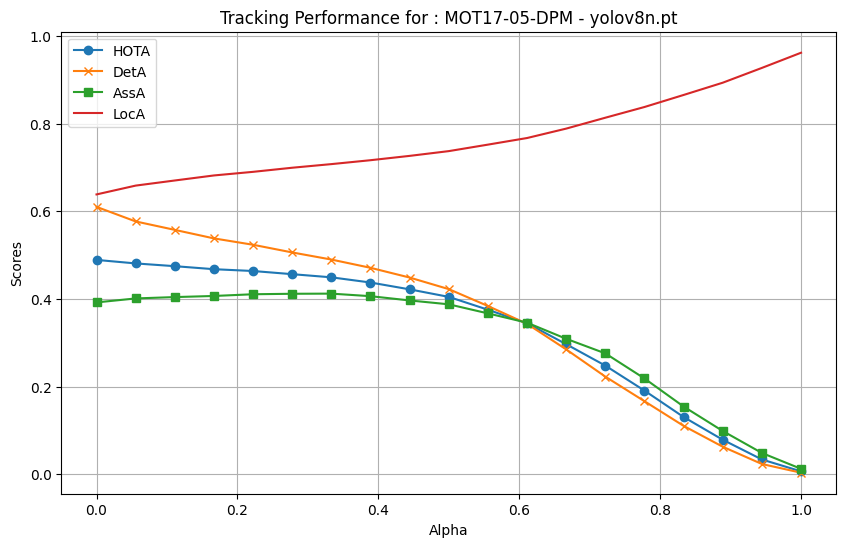

In [91]:
plot_result(output,"MOT17-05-DPM","yolov8n.pt")

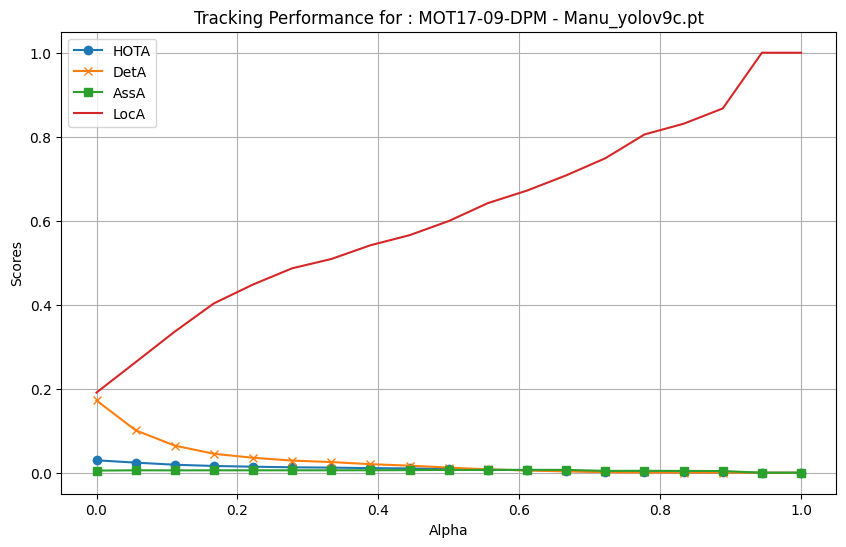

In [100]:
plot_result(output,"MOT17-09-DPM","Manu_yolov9c.pt")

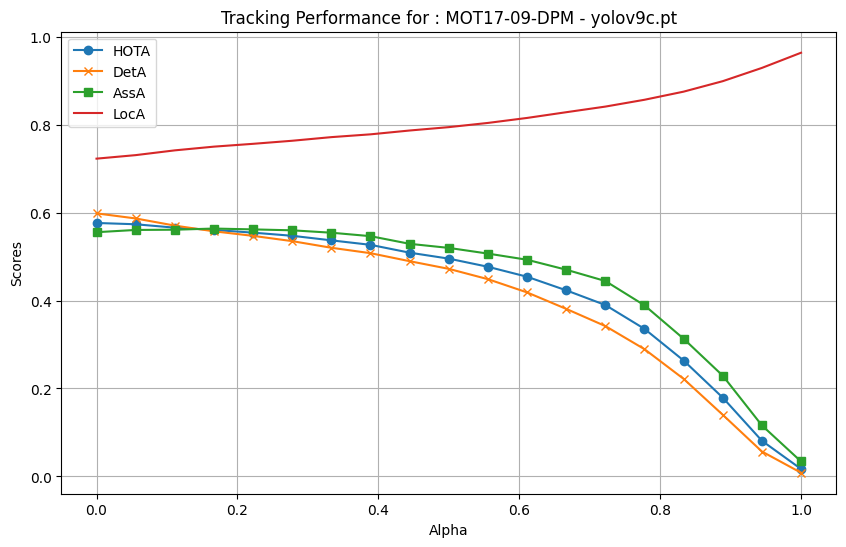

In [92]:
plot_result(output,"MOT17-09-DPM","yolov9c.pt")

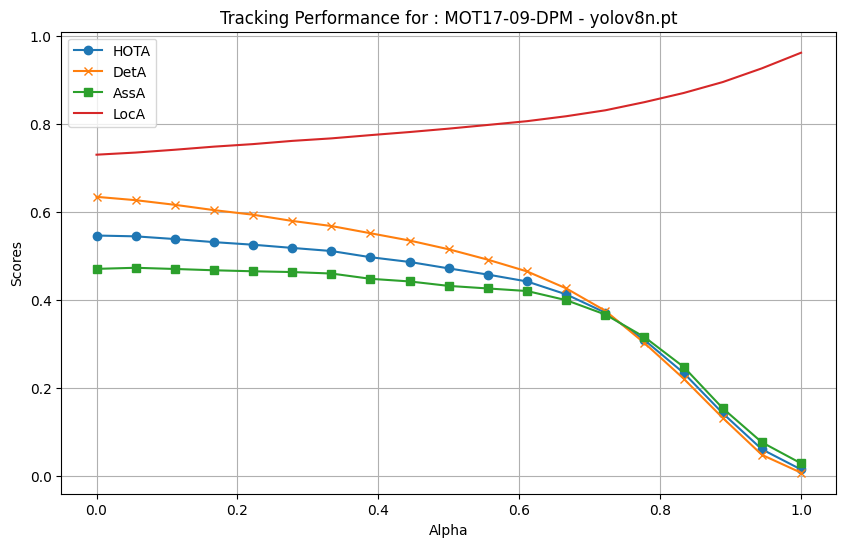

In [93]:
plot_result(output,"MOT17-09-DPM","yolov8n.pt")